# Random Forest classification on the full feature set



In [6]:
from pyspark.sql import SparkSession

#run me on the DS5110 kernel if running on Rivanna!

#Build spark session, unable to get more than 8 cores for the second half of the semester
#This configuration performs relatively well given that constraint. This application definitely wants more cores though. 
#As it is, rivanna functions similarly to a midrange laptop, hardly ideal. 

#Just kidding, we queued into a regular session, life is good. A mere several day wait. 
spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '14g') \
    .config("spark.executor.instances", "3") \
    .config('spark.executor.cores', '2') \
    .config("spark.driver.memory",'14g') \
    .config("spark.driver.maxResultSize", "6g")\
    .getOrCreate()

sc = spark.sparkContext


from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re
from pyspark.ml.feature import *
from pyspark.ml.classification import GBTClassifier
from spark_tensorflow_distributor import MirroredStrategyRunner
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [7]:
data = spark.read.parquet("clean_features.parquet2").na.drop('any')
data.show(5)

+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[1.18369388580322...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024551|HAM_0002629|ISIC_0024551| nv|follow_up|50.0|  male|        abdomen|[0.0,0.0,0.0,0.0,...|[0.01115676853805...|[0.0,0.

In [57]:
label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx')
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex')
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc')
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])


vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'mnet_vec', 'r50_vec', 'xcep_vec'], outputCol = 'Feature_vec', handleInvalid = 'skip')

#vec_index = VectorIndexer(inputCol = 'Feature_vec', outputCol = 'indexed_features', maxCategories = 8, handleInvalid = 'skip')

#define a random forest with some default values
rf = RandomForestClassifier(featuresCol = 'Feature_vec', labelCol = 'indexed_dx', featureSubsetStrategy = 'sqrt',\
                            numTrees = 200, maxDepth = 10, probabilityCol = 'probability')
pipe = Pipeline(stages = [label_index, label_sex, loc_index, OH, vec_assemb, rf])


In [9]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 20]) #Maximum tree depth
             .addGrid(rf.featureSubsetStrategy, ['50', '100', '150']) # number of variables to sample
             .addGrid(rf.numTrees, [200, 300, 400]) #number of trees
             #.addGrid(rf.maxBins, [16, 32])
             .build())

In [10]:
cv = CrossValidator(estimator=pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx"), \
                    numFolds=5, \
                    parallelism = 4,\
                    seed = 314)

In [11]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [12]:
#Stratified sample
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [13]:
test = data.subtract(train)


In [ ]:
#Call our CV model to fit on the training set
cvModel = cv.fit(train)

In [ ]:
#Evaluate performance on the validation set
results = cvModel.bestModel.transform(test)

In [44]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
preds_and_labels = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1.277e+03 2.900e+01 1.800e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.030e+02 8.400e+01 2.700e+01 4.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [9.800e+01 2.100e+01 1.150e+02 9.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [3.500e+01 8.000e+00 9.000e+00 4.900e+01 1.000e+00 0.000e+00 0.000e+00]
 [1.200e+01 1.100e+01 2.500e+01 1.800e+01 8.000e+00 0.000e+00 0.000e+00]
 [1.800e+01 0.000e+00 1.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00]
 [1.300e+01 0.000e+00 8.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00]]


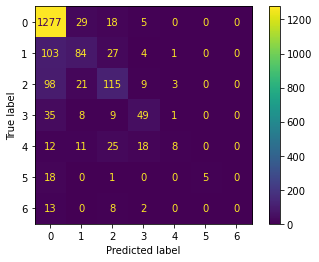

In [45]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [46]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [47]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.762519
precision,0.732416
F1 score,0.731885
FPR,0.278524
accuracy,0.762519


In [48]:
#Get Parameters for best model 
bestModel = cvModel.bestModel
trees = bestModel.stages[5].getNumTrees
strategy = bestModel.stages[5].getFeatureSubsetStrategy()
depth = bestModel.stages[5].getMaxDepth()


values = [trees, depth, strategy]
index = ['Trees', 'Depth', 'Strat']

pd.DataFrame(values, index = index, columns = ['Hyperparameter Value'])

,Hyperparameter Value
Trees,200
Depth,10
Strat,50


In [22]:
preds_and_probs = results.select(['indexed_dx', 'probability', 'prediction'])

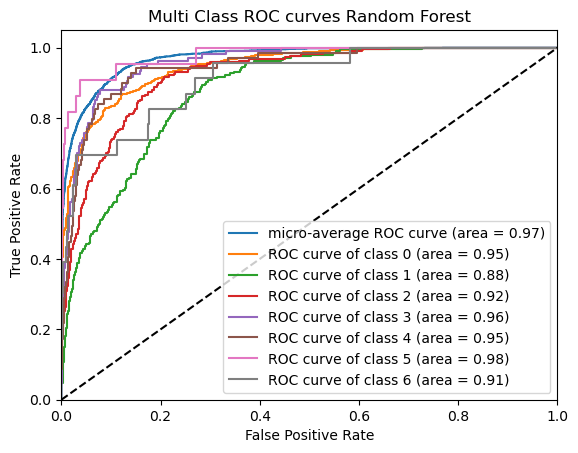

In [24]:


y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])

n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC curves Random Forest')
plt.legend(loc="lower right")
plt.show()

# Undersampling

Here we undersample to the lowest frequency class, dermofibroma. Note that class labels shift. Class 4 is now NV. We may or may not get to this in cleanup. If you're reading this, we probably didn't.

In [73]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8*.8,
 'nv': 0.8 *.017,
 'mel': 0.8*.1,
 'bcc': 0.8 * .22,
 'df': 0.8 ,
 'bkl': 0.8 * .1,
 'akiec': 0.33*.8}

In [74]:
#Stratified sample, balanced
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [75]:
test = data.subtract(train)

In [76]:
#Fit with default (optimal) hyperparameters. (sqrt = 50), we tried to be fancy and tune across that axis
#But rule of thumb appears correct here
rf_model = pipe.fit(train)

In [77]:
results = rf_model.transform(test)

In [69]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
preds_and_labels = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[3.130e+02 1.700e+01 3.200e+01 2.000e+01 7.000e+00 2.600e+01 0.000e+00]
 [2.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00]
 [2.000e+00 0.000e+00 1.200e+01 3.000e+00 3.000e+00 3.000e+00 0.000e+00]
 [1.700e+02 2.200e+01 5.500e+01 5.300e+02 5.300e+01 1.700e+02 2.000e+00]
 [2.430e+02 3.140e+02 3.640e+02 3.020e+02 4.666e+03 6.890e+02 0.000e+00]
 [1.070e+02 6.900e+01 2.800e+01 1.190e+02 1.120e+02 5.940e+02 4.000e+00]
 [1.360e+02 0.000e+00 2.800e+01 6.400e+01 5.000e+00 3.200e+01 1.900e+01]]


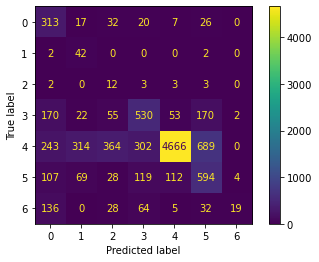

In [72]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [70]:
labels = [0.0,1.0,2.0,3.0,4.0,5.0,6.0]
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.451009,0.321686,0.754217
1,1.0,0.164706,0.090517,0.913043
2,2.0,0.044280,0.023121,0.521739
3,3.0,0.519608,0.510597,0.528942
4,4.0,0.816877,0.962856,0.709334
5,5.0,0.466065,0.391821,0.575024
6,6.0,0.122977,0.760000,0.066901


In [86]:
print('Accuracy is:' + str(metrics.accuracy))

Accuracy is:0.6583519880609743


In [81]:
preds_and_probs = results.select(['indexed_dx', 'probability', 'prediction'])

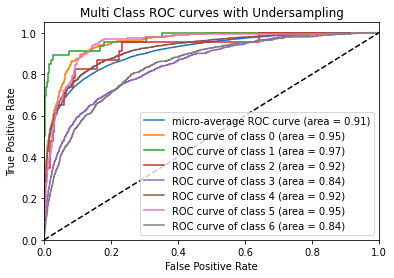

In [85]:


y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])

n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC curves with Undersampling')
plt.legend(loc="lower right")
plt.show()